# Image Classification on CIFAR-10 dataset

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import cv2

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.optimizers import Adam

### Data Exploration and Preprocessing

In [2]:
#--------------------- Load from source --------------------
from tensorflow.keras.datasets import cifar10
# Load the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#-----------------------------------------------------------
#--------------------- Load from disk ----------------------
# def unpickle(file):
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# X_train = []
# y_train = []
# for i in range(1, 6):
#     data_batch = unpickle('cifar-10-batches-py/data_batch_' + str(i))
#     X_train.append(data_batch[b'data'])
#     y_train += data_batch[b'labels']

# test_batch = unpickle('cifar-10-batches-py/test_batch')
# X_test = test_batch[b'data']
# y_test = test_batch[b'labels']

# X_train = np.concatenate(X_train)
# y_train = np.array(y_train)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

# X_train = X_train.reshape((len(X_train), 3, 32, 32)).transpose(0, 2, 3, 1)
# X_test = X_test.reshape((len(X_test), 3, 32, 32)).transpose(0, 2, 3, 1)

170498071/170498071 [==============================] - 6s 0us/step


In [3]:
# Connecting to google drive
from tensorflow.keras.datasets import cifar10
import os
from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content/drive/MyDrive')

Mounted at /content/drive


['Use case name:.gdoc',
 'Start Up.gdoc',
 'Colab Notebooks',
 'datasets',
 'cifar10-w',
 'cifar10-csv']

In [4]:
print(X_train.shape)
w = X_train.shape[1]
h = X_train.shape[2]
c = X_train.shape[3]
print(w, h, c)

(50000, 32, 32, 3)
32 32 3


### 1. Logistic Regression

In [ ]:
# (n, w, h, c) --> (n, w*h*c)
feature_size = w * h * c
X_train_flat = X_train.reshape(X_train.shape[0], feature_size)
X_test_flat = X_test.reshape(X_test.shape[0], feature_size)

In [ ]:
lr_model = LogisticRegression()
lr_fit = lr_model.fit(X_train_flat, np.ravel(y_train))

lr_y_pred_train = lr_model.predict(X_train_flat)
lr_y_pred_test = lr_model.predict(X_test_flat)

lr_train_acc = accuracy_score(y_train, lr_y_pred_train)
lr_test_acc = accuracy_score(y_test, lr_y_pred_test)

print("Final Logistic Regression Training accuracy: ", lr_train_acc)
print("Final Logistic Regression Test accuracy: ", lr_test_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Final Logistic Regression Training accuracy:  0.4258
Final Logistic Regression Test accuracy:  0.4024


### 2. Convolutional Neural Network

In [5]:
# change output layer from one column to 10 different columns per class
CNN_y_train = to_categorical(y_train, num_classes=10)
CNN_y_test = to_categorical(y_test, num_classes=10)

print(X_train.shape)
print(CNN_y_train.shape)
print(X_test.shape)
print(CNN_y_test.shape)

# initialize hyperparameters
num_classes = 10
model_optimizer = Adam(learning_rate=0.001)
model_loss = 'categorical_crossentropy'
early_stopping_patience = 3

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [ ]:
# First Sequential CNN model
default_cnn_model = Sequential([
    Conv2D(16,3,
        kernel_initializer = 'normal',
        activation = 'relu',
        input_shape=(w, h, c)),
    MaxPooling2D(2,2),

    Conv2D(32,3,
        kernel_initializer = 'normal',
        activation = 'relu'),
    MaxPooling2D(2,2),

    Conv2D(64,3,
        kernel_initializer = 'normal',
        activation = 'relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(64,
        activation = 'relu'),

    Dropout(0.2),

    Dense(
        num_classes,
        activation = 'softmax')
])

default_cnn_model.compile(optimizer = model_optimizer, loss = model_loss, metrics = ['accuracy'])
default_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 64)        

### 3. kNN

In [ ]:
def compute_histogram(image):
    # hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # hist = cv2.calcHist([hsv_image], [0], None, [256], [0, 256])

    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = hist.flatten()
    return hist

print(X_train.shape)
print(X_test.shape)
n_neighbors = 15

# change the data to their histogram
X_train_hist = np.array([compute_histogram(image) for image in X_train])
X_test_hist = np.array([compute_histogram(image) for image in X_test])

print(X_train_hist.shape)
print(X_test_hist.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 512)
(10000, 512)


In [ ]:
# Calculate KNN
knn_hist = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_hist.fit(X_train_hist, np.ravel(y_train))

y_train_pred_hist = knn_hist.predict(X_train_hist)
y_test_pred_hist = knn_hist.predict(X_test_hist)

train_accuracy_hist = accuracy_score(y_train, y_train_pred_hist)
test_accuracy_hist = accuracy_score(y_test, y_test_pred_hist)

print("Accuracy of kNN model with color histograms - Training: ", train_accuracy_hist)
print("Accuracy of kNN model with color histograms - Test: ", test_accuracy_hist)

Accuracy of kNN model with color histograms - Training:  0.44432
Accuracy of kNN model with color histograms - Test:  0.3505


In [ ]:
# Learn model on histogram data
knn_hist = KNeighborsClassifier(n_neighbors = 15)
knn_hist.fit(X_train_hist, np.ravel(y_train))

y_train_pred_hist = knn_hist.predict(X_train_hist)
y_test_pred_hist = knn_hist.predict(X_test_hist)

train_accuracy_hist = accuracy_score(y_train, y_train_pred_hist)
test_accuracy_hist = accuracy_score(y_test, y_test_pred_hist)

print('WITH K=10')
print(classification_report(y_test, y_test_pred_hist))

print("Accuracy of kNN model with color histograms - Training: ", train_accuracy_hist)
print("Accuracy of kNN model with color histograms - Test: ", test_accuracy_hist)

WITH K=10
              precision    recall  f1-score   support

           0       0.49      0.37      0.42      1000
           1       0.32      0.56      0.41      1000
           2       0.30      0.26      0.28      1000
           3       0.26      0.27      0.27      1000
           4       0.34      0.26      0.29      1000
           5       0.28      0.22      0.25      1000
           6       0.34      0.46      0.39      1000
           7       0.38      0.26      0.31      1000
           8       0.42      0.42      0.42      1000
           9       0.40      0.44      0.42      1000

    accuracy                           0.35     10000
   macro avg       0.35      0.35      0.35     10000
weighted avg       0.35      0.35      0.35     10000

Accuracy of kNN model with color histograms - Training:  0.44432
Accuracy of kNN model with color histograms - Test:  0.3505


In [ ]:
# Learn model on raw data
knn_raw = KNeighborsClassifier(n_neighbors = n_neighbors)
knn_raw.fit(X_train.reshape(X_train.shape[0], -1), y_train)

y_train_pred_raw = knn_raw.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_raw = knn_raw.predict(X_test.reshape(X_test.shape[0], -1))

train_accuracy_raw = accuracy_score(y_train, y_train_pred_raw)
test_accuracy_raw = accuracy_score(y_test, y_test_pred_raw)

print("Accuracy of kNN model with raw images - Training: ", train_accuracy_raw )
print("Accuracy of kNN model with raw images - Test: ", test_accuracy_raw)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of kNN model with raw images - Training:  0.39846
Accuracy of kNN model with raw images - Test:  0.3405


## Parameter Tuning

#### 1. Convolutional Neural Network

In [6]:
# create base model for grid search
def model_CNN(hidden_layers = 1, units = 1, kernel_initializer = 'normal', activation = 'relu'):
    base_unit = 3
    model = Sequential()

    for i in range(hidden_layers):
        model.add(Conv2D(2 ** (base_unit + units), (3, 3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer, input_shape=(w, h, c)))
    model.add(MaxPooling2D(2, 2))

    for i in range(hidden_layers):
        model.add(Conv2D(2 ** (base_unit + 1 + units), (3, 3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer))
    model.add(MaxPooling2D(2, 2))

    for i in range(hidden_layers):
        model.add(Conv2D(2 ** (base_unit + 2 + units), (3, 3), activation = activation, padding = 'same', kernel_initializer = kernel_initializer))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    model.add(Dense(2 ** (base_unit + 2 + units), activation = activation))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation = 'softmax'))

    model.compile(optimizer = model_optimizer, loss = model_loss, metrics = ['accuracy'])

    return model

In [ ]:
model_CNN_keras = KerasClassifier(build_fn = model_CNN, epochs = 5)

hyperparameters_grid = {
    'hidden_layers': [1, 2, 3],
    'units': [1, 2],
    'kernel_initializer': ['uniform', 'normal'],
    'activation': ['relu', 'tanh']
}

# Using Shuffle Split to splits 1/5 for validation set for finding best hyperparameters
grid = GridSearchCV(estimator = model_CNN_keras, param_grid = hyperparameters_grid, cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42), verbose = 5)
grid_fit = grid.fit(X_train, CNN_y_train)

<ipython-input-56-3c4ed4dc763b>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_CNN_keras = KerasClassifier(build_fn = model_CNN, epochs = 5)


Fitting 1 folds for each of 24 candidates, totalling 24 fits
Epoch 1/5
1250/1250 [==============================] - 5s 4ms/step - loss: 2.0365 - accuracy: 0.2415
Epoch 2/5
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7868 - accuracy: 0.3362
Epoch 3/5
1250/1250 [==============================] - 4s 3ms/step - loss: 1.7013 - accuracy: 0.3697
Epoch 4/5
1250/1250 [==============================] - 5s 4ms/step - loss: 1.6360 - accuracy: 0.3952
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 1.4454 - accuracy: 0.4828
[CV 1/1] END activation=relu, hidden_layers=1, kernel_initializer=uniform, units=1;, score=0.483 total time=  43.4s
Epoch 1/5
1250/1250 [==============================] - 7s 5ms/step - loss: 1.8035 - accuracy: 0.3546
Epoch 2/5
1250/1250 [==============================] - 6s 5ms/step - loss: 1.4345 - accuracy: 0.4907
Epoch 3/5
1250/1250 [==============================] - 8s 7ms/step - loss: 1.2995 - accuracy: 0.5430
Epoch 4/5
1250/12

In [ ]:
df_grid = pd.DataFrame(grid_fit.cv_results_)
print(df_grid[['params', 'rank_test_score']])

df_grid.to_csv('/content/drive/MyDrive/cifar10-csv/cnn_model.csv', index=False)
# df_grid.to_csv('cnn_model.csv', index=False)

                                               params  rank_test_score
0   {'activation': 'relu', 'hidden_layers': 1, 'ke...                5
1   {'activation': 'relu', 'hidden_layers': 1, 'ke...                2
2   {'activation': 'relu', 'hidden_layers': 1, 'ke...                4
3   {'activation': 'relu', 'hidden_layers': 1, 'ke...                1
4   {'activation': 'relu', 'hidden_layers': 2, 'ke...               21
5   {'activation': 'relu', 'hidden_layers': 2, 'ke...               19
6   {'activation': 'relu', 'hidden_layers': 2, 'ke...               17
7   {'activation': 'relu', 'hidden_layers': 2, 'ke...                3
8   {'activation': 'relu', 'hidden_layers': 3, 'ke...               21
9   {'activation': 'relu', 'hidden_layers': 3, 'ke...               15
10  {'activation': 'relu', 'hidden_layers': 3, 'ke...               12
11  {'activation': 'relu', 'hidden_layers': 3, 'ke...               21
12  {'activation': 'tanh', 'hidden_layers': 1, 'ke...               12
13  {'

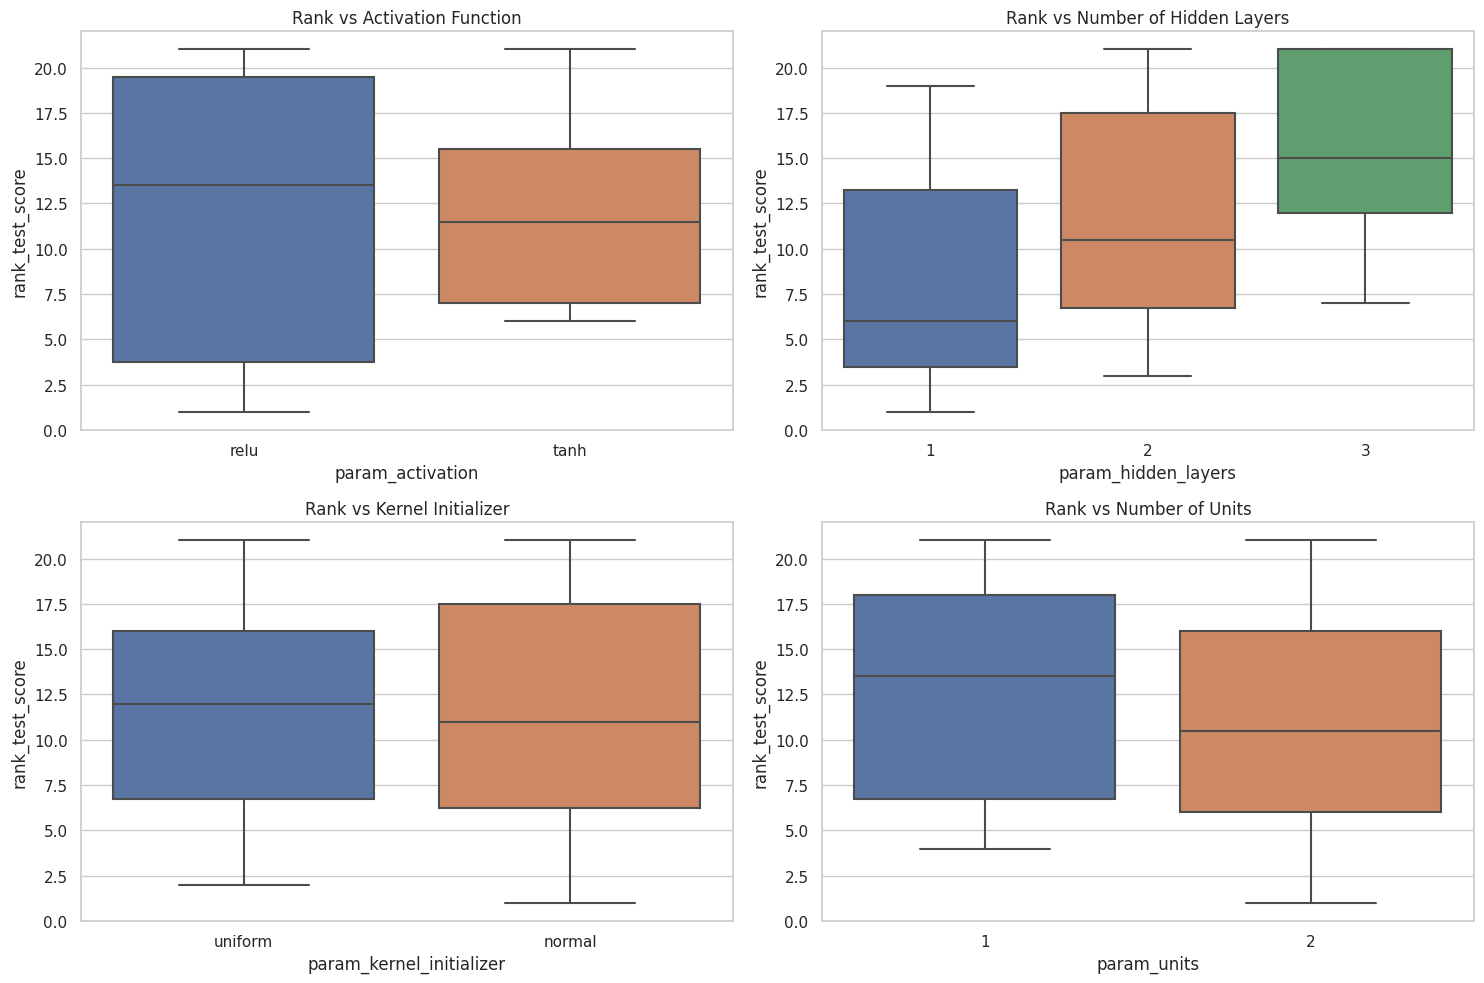

In [ ]:
df_grid_temp = df_grid[['param_activation', 'param_hidden_layers', 'param_kernel_initializer', 'param_units', 'rank_test_score']]

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

sns.boxplot(x="param_activation", y="rank_test_score", data=df_grid_temp, ax=axes[0, 0])
axes[0, 0].set_title("Rank vs Activation Function")
sns.boxplot(x="param_hidden_layers", y="rank_test_score", data=df_grid_temp, ax=axes[0, 1])
axes[0, 1].set_title("Rank vs Number of Hidden Layers")
sns.boxplot(x="param_kernel_initializer", y="rank_test_score", data=df_grid_temp, ax=axes[1, 0])
axes[1, 0].set_title("Rank vs Kernel Initializer")
sns.boxplot(x="param_units", y="rank_test_score", data=df_grid_temp, ax=axes[1, 1])
axes[1, 1].set_title("Rank vs Number of Units")

plt.tight_layout()
plt.show()

In [7]:
# Set the best hyperparameters
hidden_layers = 2
units = 2
kernel_initializer = 'normal'
activation = 'relu'

In [8]:
cnn_final_model = model_CNN(hidden_layers = hidden_layers, units = units, kernel_initializer = kernel_initializer, activation = activation)
cnn_final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

In [9]:
early_stopping = EarlyStopping(patience = early_stopping_patience)
trained_cnn_final_model = cnn_final_model.fit(X_train, CNN_y_train, batch_size=32, epochs=20, validation_data=(X_test, CNN_y_test), callbacks=[early_stopping])
cnn_final_model.save('/content/drive/MyDrive/cifar10-w/cnn_model.h5')

Epoch 1/20
1563/1563 [==============================] - 19s 6ms/step - loss: 1.6612 - accuracy: 0.4177 - val_loss: 1.2764 - val_accuracy: 0.5407
Epoch 2/20
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1817 - accuracy: 0.5864 - val_loss: 1.0463 - val_accuracy: 0.6344
Epoch 3/20
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0062 - accuracy: 0.6502 - val_loss: 0.9865 - val_accuracy: 0.6700
Epoch 4/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9075 - accuracy: 0.6839 - val_loss: 0.9255 - val_accuracy: 0.6835
Epoch 5/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8320 - accuracy: 0.7154 - val_loss: 0.8818 - val_accuracy: 0.7004
Epoch 6/20
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7685 - accuracy: 0.7341 - val_loss: 0.9108 - val_accuracy: 0.6890
Epoch 7/20
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7312 - accuracy: 0.7460 - val_loss: 0.8273 - val_accura

313/313 [==============================] - 1s 4ms/step - loss: 0.8294 - accuracy: 0.7335
CNN Train Accuracy: 0.8258200287818909
CNN Test Accuracy: 0.7335000038146973


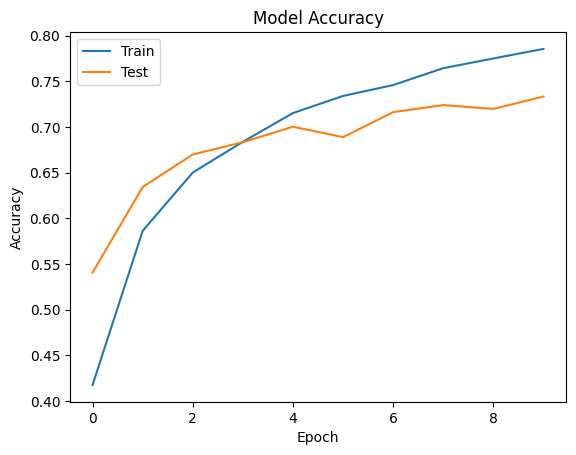

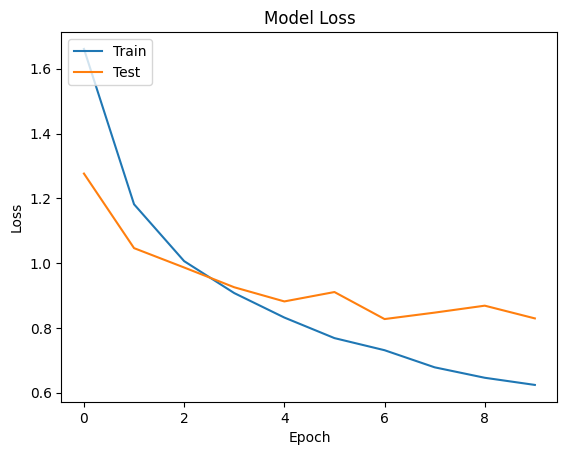

313/313 [==============================] - 1s 2ms/step


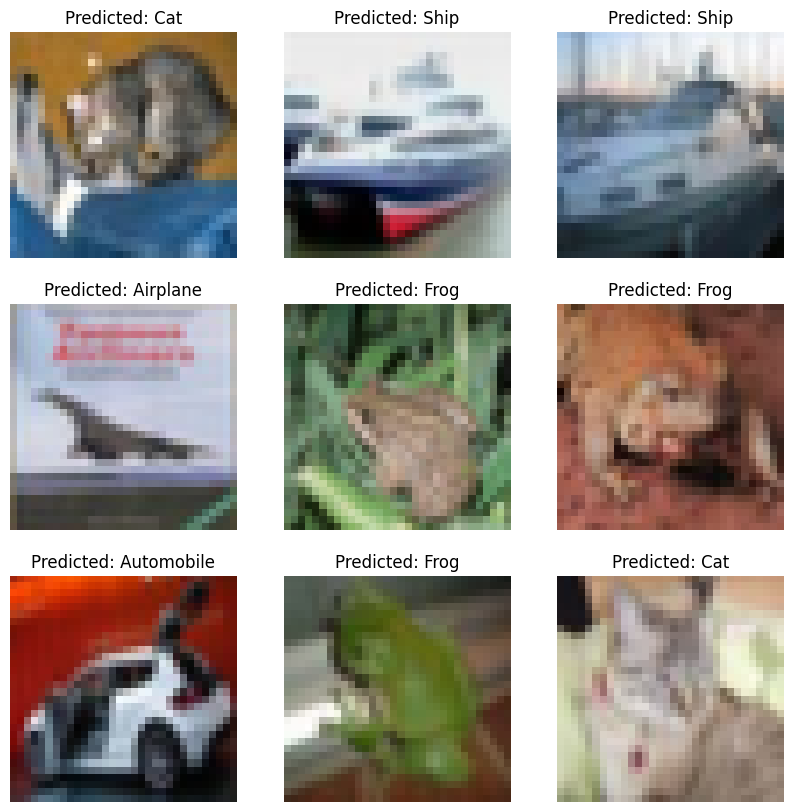

In [10]:
train_loss, cnn_train_accuracy = cnn_final_model.evaluate(X_train, CNN_y_train)
test_loss, cnn_test_accuracy = cnn_final_model.evaluate(X_test, CNN_y_test)

print('CNN Train Accuracy:', cnn_train_accuracy)
print('CNN Test Accuracy:', cnn_test_accuracy)

plt.plot(trained_cnn_final_model.history['accuracy'])
plt.plot(trained_cnn_final_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained_cnn_final_model.history['loss'])
plt.plot(trained_cnn_final_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

y_pred = cnn_final_model.predict(X_test)

class_labels = np.argmax(y_pred, axis=1)

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    ax.set_title(f'Predicted: {class_names[class_labels[i]]}')
    ax.axis('off')
plt.show()

#### 2. KNN

In [ ]:
# Elbow method to find best k
error_rate = []

for i in range(1,20):
    print(i)
    knn = KNeighborsClassifier(n_neighbors = i)
    score = cross_val_score(knn, X_train.reshape(X_train.shape[0], -1), np.ravel(y_train), cv = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42), verbose = 5)
    error_rate.append(1 - score.mean())

1
[CV] END ................................ score: (test=0.336) total time= 1.3min
2
[CV] END ................................ score: (test=0.302) total time= 1.4min
3
[CV] END ................................ score: (test=0.322) total time= 1.3min
4
[CV] END ................................ score: (test=0.331) total time= 1.4min
5
[CV] END ................................ score: (test=0.333) total time= 1.5min
6
[CV] END ................................ score: (test=0.329) total time= 1.4min
7
[CV] END ................................ score: (test=0.330) total time= 1.3min
8
[CV] END ................................ score: (test=0.331) total time= 1.3min
9
[CV] END ................................ score: (test=0.331) total time= 1.3min
10
[CV] END ................................ score: (test=0.329) total time= 1.3min
11
[CV] END ................................ score: (test=0.327) total time= 1.3min
12
[CV] END ................................ score: (test=0.326) total time= 1.4min
1

Text(0, 0.5, 'Error Rate')

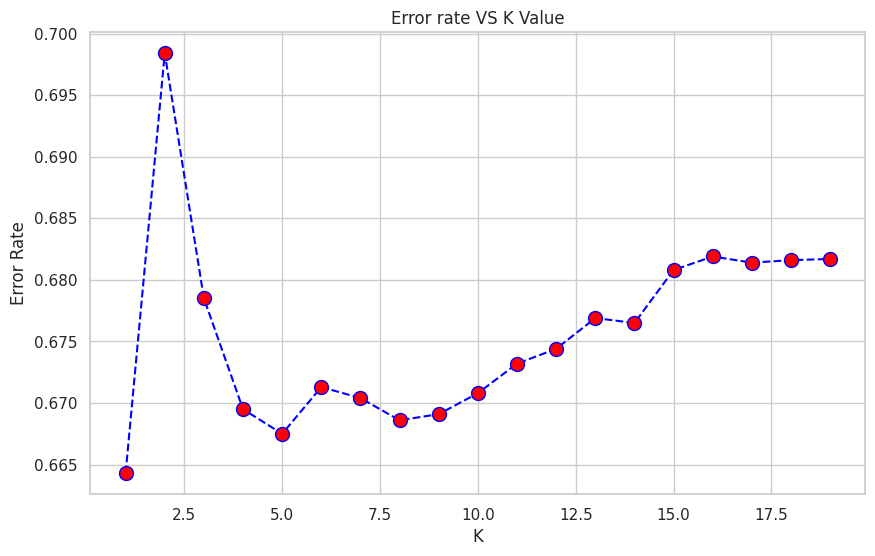

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)

plt.title('Error rate VS K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
# Set the best n_neighbors
best_n_neighbors =  10

In [ ]:
# Create final KNN model on best n_neighbors
knn_final = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)

y_train_pred_final = knn_final.predict(X_train.reshape(X_train.shape[0], -1))
y_test_pred_final = knn_final.predict(X_test.reshape(X_test.shape[0], -1))

knn_train_accuracy_final = accuracy_score(y_train, y_train_pred_final)
knn_test_accuracy_final = accuracy_score(y_test, y_test_pred_final)

print("Accuracy of kNN model with final images - Training: ", knn_train_accuracy_final)
print("Accuracy of kNN model with final images - Test: ", knn_test_accuracy_final)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of kNN model with final images - Training:  0.39096
Accuracy of kNN model with final images - Test:  0.341


### 3. Clustering

In [ ]:
kmeans = KMeans(n_clusters = 10, random_state = 42)
clusters = kmeans.fit_predict(X_train_hist)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
from collections import Counter

cluster_label_counts = {cluster: Counter() for cluster in range(10)}

for cluster, label in zip(clusters, y_train):
    label_tuple = tuple(label)
    cluster_label_counts[cluster][label_tuple] += 1

for cluster, label_count in cluster_label_counts.items():
    print(f"Cluster {cluster}: {label_count}")


Cluster 0: Counter({(9,): 1117, (1,): 590, (8,): 519, (7,): 493, (0,): 413, (3,): 393, (5,): 318, (2,): 163, (4,): 157, (6,): 153})
Cluster 1: Counter({(6,): 1652, (5,): 1424, (7,): 1414, (3,): 1379, (4,): 1065, (2,): 909, (9,): 378, (1,): 365, (0,): 253, (8,): 92})
Cluster 2: Counter({(8,): 514, (0,): 499, (5,): 463, (3,): 452, (2,): 398, (9,): 335, (1,): 331, (4,): 264, (7,): 243, (6,): 236})
Cluster 3: Counter({(1,): 541, (9,): 539, (3,): 515, (4,): 506, (2,): 492, (5,): 460, (8,): 442, (6,): 421, (0,): 380, (7,): 370})
Cluster 4: Counter({(8,): 2377, (0,): 2065, (1,): 937, (9,): 845, (2,): 699, (4,): 450, (5,): 328, (7,): 324, (3,): 295, (6,): 179})
Cluster 5: Counter({(3,): 538, (5,): 403, (6,): 377, (1,): 355, (7,): 264, (2,): 247, (4,): 231, (9,): 182, (8,): 113, (0,): 101})
Cluster 6: Counter({(0,): 390, (8,): 337, (5,): 209, (3,): 179, (9,): 169, (2,): 142, (1,): 121, (7,): 93, (4,): 76, (6,): 76})
Cluster 7: Counter({(1,): 1248, (9,): 1102, (3,): 764, (5,): 745, (7,): 651, (4

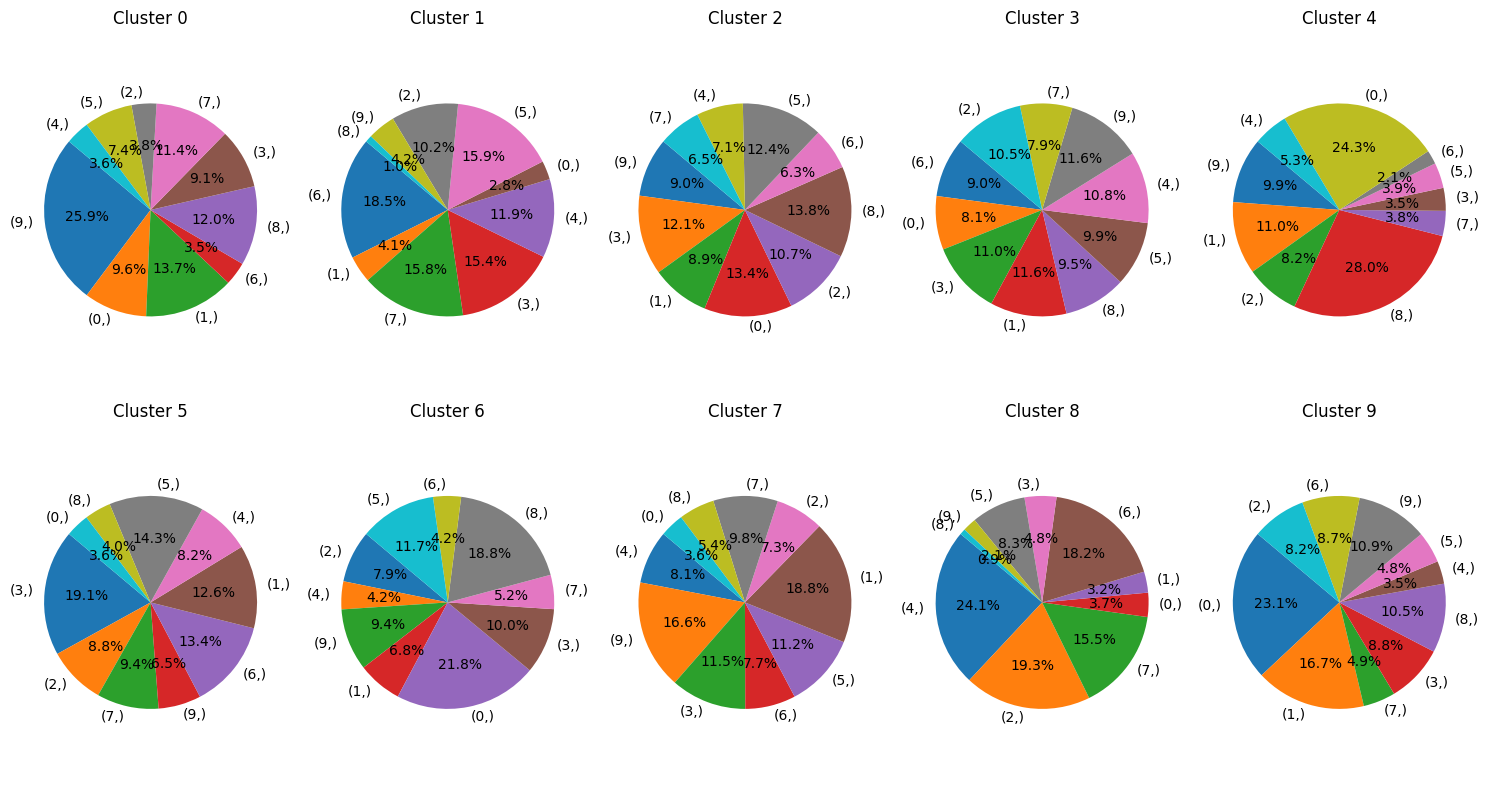

In [ ]:
num_clusters = len(cluster_label_counts)
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
axes = axes.flatten()

for cluster_id, data in cluster_label_counts.items():
    ax = axes[cluster_id]

    values = list(data.values())
    labels = [str(key) for key in data.keys()]

    ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Cluster {cluster_id}')
    ax.axis('equal')

for i in range(num_clusters, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
train_labels = kmeans.labels_
test_labels = kmeans.predict(X_test_hist)

train_accuracy = accuracy_score(y_train, train_labels)
test_accuracy = accuracy_score(y_test, test_labels)
print("Test accuracy:", test_accuracy)
print("Training accuracy:", train_accuracy)

Test accuracy: 0.0718
Training accuracy: 0.07346


In [ ]:
clusters = kmeans.fit_predict(X_train_hist)

In [ ]:
print(X_train_hist.shape)
print(y_train.shape)
print(clusters.shape)

(50000, 512)
(50000, 1)
(50000,)


## Results Analysis

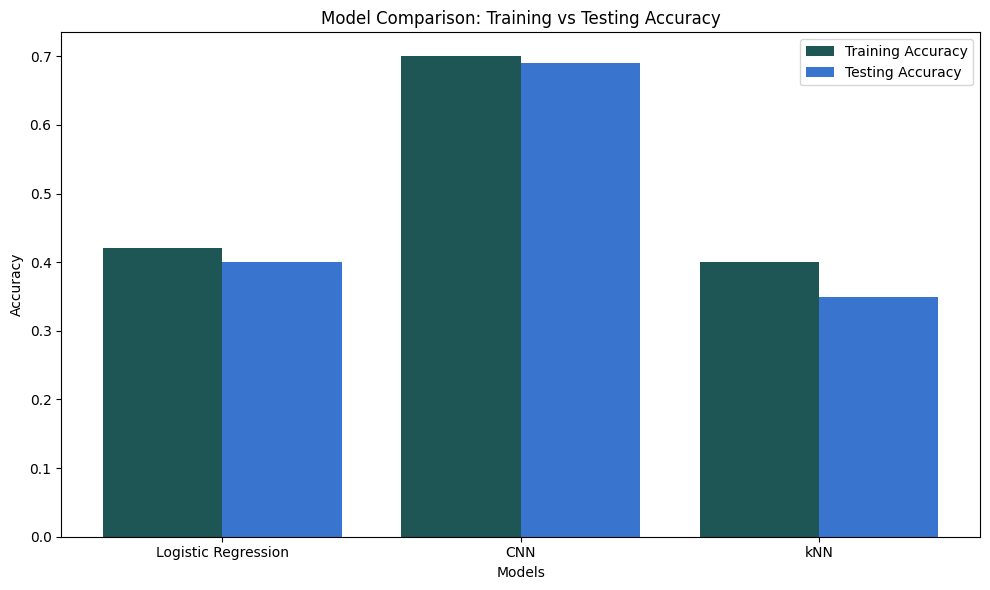

In [ ]:
models = ['Logistic Regression', 'CNN', 'kNN']
train_accuracies = [lr_train_acc, cnn_train_accuracy, knn_train_accuracy_final]
test_accuracies = [lr_test_acc, cnn_test_accuracy, knn_test_accuracy_final]

index = np.arange(len(models))
plt.figure(figsize=(10, 6))
plt.bar(index, train_accuracies, color='#1e5655', width=0.4, label='Training Accuracy')
plt.bar(index + 0.4, test_accuracies, color='#3974ce', width=0.4, label='Testing Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Training vs Testing Accuracy')
plt.xticks(index + 0.4 / 2, models)
plt.legend()
plt.tight_layout()

plt.show()